In [2]:
import pandas as pd
import json

In [3]:
cfg = {
    'DIR': '../dataset/',
    'train_path': 'train.json',
    'test_path': 'test.json',
    'dev_path': 'dev.json',
}

In [4]:
from nltk import word_tokenize

def tokenize(str: str) -> str:
    return ' '.join(word_tokenize(str))

In [5]:
import os

def load_data(path: str) -> json:
    with open(os.path.join(cfg['DIR'], path), 'r') as f:
        data = json.load(f)
    return data

In [7]:
from sklearn.preprocessing import LabelEncoder

def get_labels() -> dict:
    return {
        'NotMentioned': 0,
        'Entailment': 1,
        'Contradiction': 2,
    }

In [19]:
def get_hypothesis(data: dict) -> list:
    hypothesis = {}
    majority_ct = {} # storing the counts
    for key, value in data['labels'].items():
        hypothesis[key] = value['hypothesis']
        majority_ct[key] = {'NotMentioned': 0, 'Entailment': 0, 'Contradiction': 0}
    return hypothesis, majority_ct

In [28]:
train = load_data(cfg['train_path'])
hypothesis, majority_ct = get_hypothesis(train)
labels = get_labels()

In [29]:
for doc in train['documents']:
    for key, value in doc['annotation_sets'][0]['annotations'].items():
        majority_ct[key][value['choice']] += 1

for key, value in majority_ct.items():
    majority_ct[key] = max(value, key=value.get)

In [31]:
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

wandb.init(entity="contract-nli-db", project="majority_vote")
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shu7bh (contract-nli-db). Use `wandb login --relogin` to force relogin
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


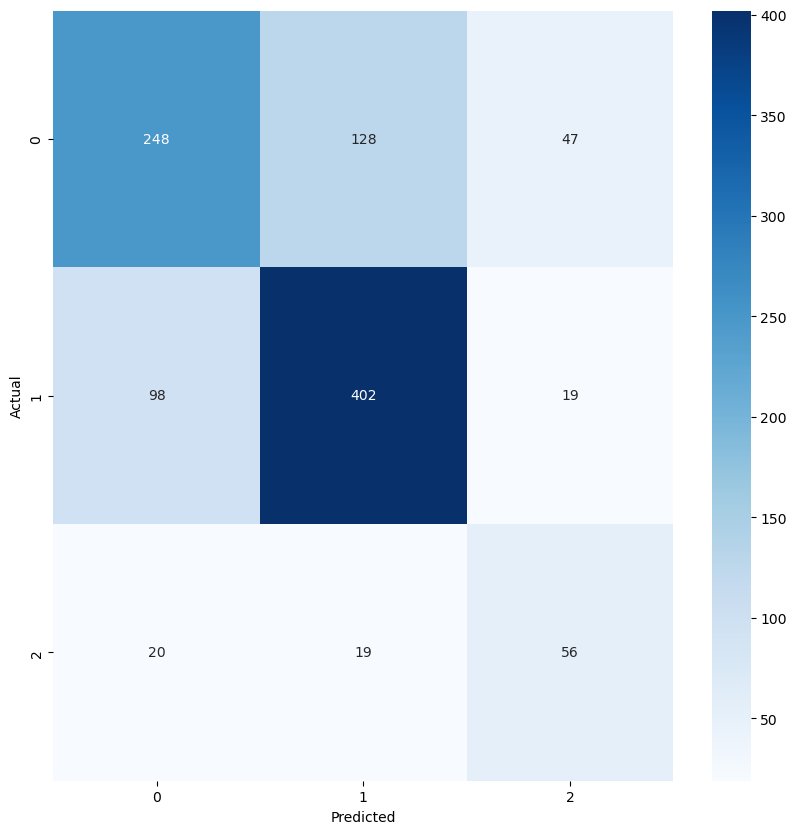

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

dev = load_data(cfg['dev_path'])

Y_true = []
Y_pred = []

for doc in dev['documents']:
    for key, value in doc['annotation_sets'][0]['annotations'].items():
        Y_true.append(labels[value['choice']])
        Y_pred.append(labels[majority_ct[key]])

report = classification_report(Y_true, Y_pred, output_dict=True)
wandb.log(report)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('majority_vote.png')
wandb.log({'confusion_matrix': wandb.Image('majority_vote.png')})

In [34]:
wandb.finish()
os.remove('majority_vote.png')

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,0.68081
